<a href="https://colab.research.google.com/github/Amelet/DeepLearning_TensorFLow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

import matplotlib.image as mpimg
import os
import random
import matplotlib.pyplot as plt

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

--2023-08-08 11:38:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-08 11:38:26 (81.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2023-08-08 11:38:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.128, 142.250.159.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  97.0MB/s    in 15s     

2023-08-08 11:38:43 (103 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                shuffle=False,
                                                                image_size=IMG_SIZE) # we do not shuffle test data for the prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
print('train_data_all_10_percent\n', train_data_all_10_percent)
print('test_data\n', test_data)

train_data_all_10_percent
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>
test_data
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>


# Train the model with transfer learning on 10% of 101 food classes

Steps:
1. Create a model checkpoint callback (saves model as it trains)
2. Create a data augmentation layer to build data augmentation right into the model
3. Build headless (no top layers) Functional EfficialNetB0 backboned-model
4. Compile the model
5. Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of test data to save epoch time)


In [ ]:
# Create CheckPoint Callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoints"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# create data augmentation layer to incorporate it right into the model

# Setup
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs between 0 and 1, needed for some models where this is not built into the model
])

In [ ]:
# Setup the basemodel abd freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setupo model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augmentation happens only during training)
x = base_model(x, training=False) # put the base model in inference mode and all layers are frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),
                      activation="softmax",
                      name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# get a summary of model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

initial_epochs = 5

history_model = model.fit(train_data_all_10_percent,
                          epochs=initial_epochs,
                          steps_per_epoch=len(train_data_all_10_percent),
                          validation_steps=int(0.15*len(test_data)),
                          validation_data=test_data,
                          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 929s 4s/step - loss: 3.3728 - accuracy: 0.2785 - val_loss: 2.4902 - val_accuracy: 0.4608
Epoch 2/5
237/237 [==============================] - 908s 4s/step - loss: 2.2001 - accuracy: 0.5005 - val_loss: 2.0708 - val_accuracy: 0.5117
Epoch 3/5
237/237 [==============================] - 839s 4s/step - loss: 1.8264 - accuracy: 0.5666 - val_loss: 1.8446 - val_accuracy: 0.5487
Epoch 4/5
237/237 [==============================] - 902s 4s/step - loss: 1.6089 - accuracy: 0.6048 - val_loss: 1.7759 - val_accuracy: 0.5538
Epoch 5/5
237/237 [==============================] - 841s 4s/step - loss: 1.4569 - accuracy: 0.6418 - val_loss: 1.7238 - val_accuracy: 0.5596


In [ ]:
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 1729s 2s/step - loss: 1.5817 - accuracy: 0.5846


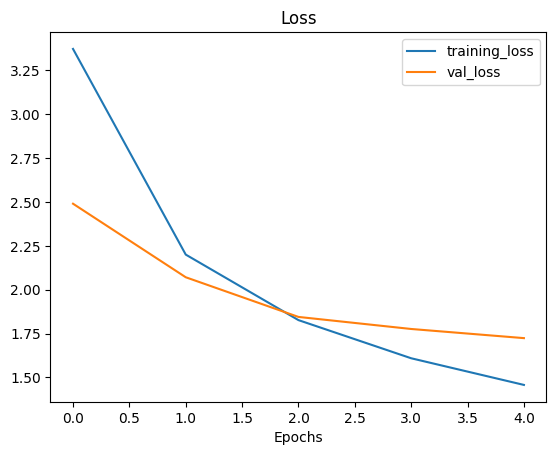

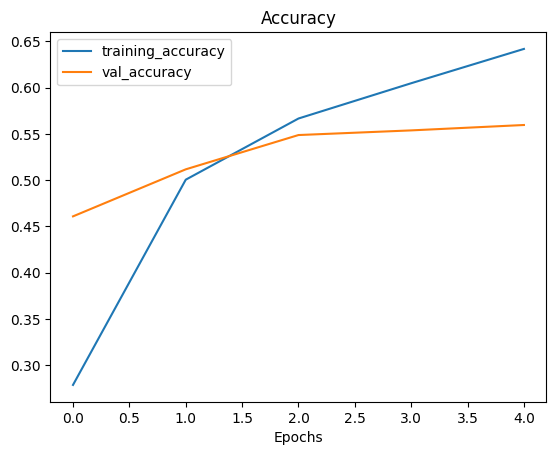

In [ ]:
plot_loss_curves(history_model)

we see that model overfits, and we are going to fine-tune the model

# Fine-Tuning
unfreeze some layers in the base-model

In [ ]:
# unfreeze all
base_model.trainable = True

# Refreeze every layer except the last five where the most detailed patterns are learned
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# recompile the model with a lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# which layers are trainable:
for layer in model.layers:
  print(layer.name, layer.trainable)

# which layers are trainable:
for layer in model.layers[2].layers:
  print(layer.name, layer.trainable)

input_layer True
sequential True
efficientnetb0 True
global_avg_pool_layer True
output_layer True
input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_

In [ ]:
fine_tune_epochs = 10 # model has done 5 already
history_model1 = model.fit(train_data_all_10_percent,
                           epochs=fine_tune_epochs,
                           initial_epoch=history_model.epoch[-1],
                           steps_per_epoch=len(train_data_all_10_percent),
                           validation_steps=int(0.15*len(test_data)),
                           validation_data=test_data,
                           callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 907s 4s/step - loss: 1.2055 - accuracy: 0.6857 - val_loss: 1.6782 - val_accuracy: 0.5604
Epoch 6/10
237/237 [==============================] - 863s 4s/step - loss: 1.0953 - accuracy: 0.7072 - val_loss: 1.6561 - val_accuracy: 0.5659
Epoch 7/10
237/237 [==============================] - 940s 4s/step - loss: 1.0199 - accuracy: 0.7312 - val_loss: 1.6682 - val_accuracy: 0.5657


In [ ]:
fine_tuning_results = model.evaluate(test_data)

In [ ]:
plot_loss_curves(history_model1)

In [ ]:
compare_historys(original_history=history_model, new_history=history_model1, initial_epochs=5)

loss curves are separated a lot, we still overfit, we need to use methods that prevent overfitting

# Save and load the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Save model
model.save("drive/MyDive/tensorflow_course/101_food_classes_10_percent_saved_101FoodModel")

In [ ]:
# Load model
loaded_model = tf.keras.models.load_model("drive/MyDive/tensorflow_course/101_food_classes_10_percent_saved_101FoodModel")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
# their results must be close
loaded_model_results = loaded_model.evaluate(test_data)

# Check predictions
evaluate the performance of the model across all different classes.

Here we aim to identify which classes are not identified well

In [ ]:
# Make predictions with the model
preds_probs = model.predict(test_data, verbose=1)
print(len(preds_probs))